In [1]:
!pip install nltk

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# The drive.mount cell is gone!

# Only try this if re-uploading fails multiple times
try:
    with open('/kaggle/input/capstone-project/train_data1.json', 'r', encoding='utf-8-sig') as file:
        all_data = json.load(file)
except UnicodeDecodeError:
    print("UTF-8-SIG failed, trying latin-1...")
    with open('/kaggle/input/test-dtata/test_data1_final.json', 'r', encoding='latin-1') as file:
        all_data = json.load(file)

In [4]:
nltk.download('punkt_tab')
# import nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# Process JSON data
source_sentences_train = []
target_sentences_train = []

source_sentences_val = []
target_sentences_val = []

id_train = []
id_val = []

In [6]:
# Change 'data.items()' to 'all_data.items()'
for language_pair, language_data in all_data.items():
    print(f"Language Pair: {language_pair}")

Language Pair: English-Bengali
Language Pair: English-Hindi


In [7]:
# for language_pair, language_data in data.items():
#     if(language_pair == "English-Bengali"):
#       print(f"Language Pair: {language_pair}")
#       for data_type, data_entries in language_data.items():
#           print(f"  Data Type: {data_type}")
#           for entry_id, entry_data in data_entries.items():
#               source = entry_data["source"]
#               target = entry_data["target"]
#               if (data_type == "Validation"):
#                 source_sentences_val.append(source)
#                 target_sentences_val.append(target)
#                 id_val.append(entry_id)
#               else:
#                 source_sentences_train.append(source)
#                 target_sentences_train.append(target)
#                 id_train.append(entry_id)

In [8]:
# with open('/kaggle/input/capstone-project/val_data1.json', 'r') as file: # Replace this path with the dataset path in your local machine
    # data = json.load(file)

In [9]:
# for language_pair, language_data in data.items():
#     if(language_pair == "English-Bengali"):
#       print(f"Language Pair: {language_pair}")
#       for data_type, data_entries in language_data.items():
#           print(f"  Data Type: {data_type}")
#           for entry_id, entry_data in data_entries.items():
#               source = entry_data["source"]
              #target = entry_data["target"]
              # if (data_type == "Validation"):
              #   source_sentences_val.append(source)
                #target_sentences_val.append(target)
                #id_val.append(entry_id)
              #else:
                #source_sentences_train.append(source)
                #target_sentences_train.append(target)
                #id_train.append(entry_id)

In [10]:
# import json
# from sklearn.model_selection import train_test_split

# --- 1. Load all available labeled data ---
# print("Loading all available training data...")
# with open('/kaggle/input/capstone/train_data1.json', 'r') as file:
#     all_data = json.load(file)

# source_sentences_full = []
# target_sentences_full = []

# This example is for Bengali, change to "English-Hindi" for the other run
# for entry_id, entry_data in all_data["English-Bengali"]["Train"].items():
#     source_sentences_full.append(entry_data["source"])
#     target_sentences_full.append(entry_data["target"])

# print(f"Total labeled sentences found: {len(source_sentences_full)}")


# --- 2. Split the data into training and validation sets ---
# print("Splitting data into training and validation sets...")
# source_sentences_train, source_sentences_val, target_sentences_train, target_sentences_val = train_test_split(
#     source_sentences_full,
#     target_sentences_full,
#     test_size=0.1,
#     random_state=42
# )


# --- 3. Load the unlabeled test data for final prediction ---
# print("Loading unlabeled test data...")
# with open('/kaggle/input/capstone/val_data1.json', 'r') as file:
#     test_data = json.load(file)

# This is the line that creates the variable you are missing
# source_sentences_test = []
# id_test = []

# for entry_id, entry_data in test_data["English-Bengali"]["Validation"].items():
#     source_sentences_test.append(entry_data["source"])
#     id_test.append(entry_id)


# --- 4. Verify the final counts ---
# print("\n--- Data Loading Complete ---")
# print(f"Training sentences:   {len(source_sentences_train)}")
# print(f"Validation sentences: {len(source_sentences_val)}")
# print(f"Test sentences:       {len(source_sentences_test)}")

In [11]:
import re
import string
import nltk
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Function to preprocess (remove punctuation/digits, lower, tokenize)
def preprocess_sentence(sentence):
    # Remove punctuation and digits (consider keeping digits if relevant)
    sentence = ''.join([char for char in sentence if char not in string.punctuation and not char.isdigit()])
    # Lowercase and tokenize
    return nltk.word_tokenize(sentence.lower())

# Function to build vocabulary
def build_vocab(tokenized_sentences, max_vocab_size=30000): # Limit vocab size
    word_counts = Counter()
    for sentence in tokenized_sentences:
        for word in sentence:
            word_counts[word] += 1

    # Keep most common words + special tokens
    common_words = word_counts.most_common(max_vocab_size - 4) # Reserve space for 4 special tokens
    index2word = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"] + [word for word, count in common_words]
    word2index = {word: idx for idx, word in enumerate(index2word)}
    return word2index, index2word

# Function to encode and pad sentences
def encode_and_pad(vocab_map, sentence_tokens, max_length):
    sos = [vocab_map["<SOS>"]]
    eos = [vocab_map["<EOS>"]]
    pad = vocab_map["<PAD>"]
    unk = vocab_map["<UNK>"]

    encoded = [vocab_map.get(w, unk) for w in sentence_tokens]

    padding_needed = max_length - len(encoded) - 2 # Account for SOS and EOS

    if padding_needed >= 0:
        return sos + encoded + eos + [pad] * padding_needed
    else:
        # Truncate if too long
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

# --- Set sequence length (can be adjusted) ---
seq_length = 64 # Increased from previous attempts
batch_size = 32 # Increased batch size (adjust based on GPU memory)
max_vocab = 30000 # Limit vocabulary size

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
from sklearn.model_selection import train_test_split
import json

def load_and_split_language(lang_pair_key, train_file, test_file, random_state=42, test_size=0.1):
    print(f"\n--- Loading and Splitting Data for {lang_pair_key} ---")
    # Load training data
    with open(train_file, 'r', encoding='utf-8') as f:
        all_train_data = json.load(f)

    source_full = []
    target_full = []
    if lang_pair_key in all_train_data and "Train" in all_train_data[lang_pair_key]:
        for entry_id, entry_data in all_train_data[lang_pair_key]["Train"].items():
            source_full.append(entry_data["source"])
            target_full.append(entry_data["target"])
    else:
        raise ValueError(f"Training data not found for {lang_pair_key}")

    print(f"Total training pairs found: {len(source_full)}")

    # Split into train and validation
    source_train, source_val, target_train, target_val = train_test_split(
        source_full, target_full, test_size=test_size, random_state=random_state
    )
    print(f"Split into {len(source_train)} train / {len(source_val)} validation pairs.")
    # Load test data (sources only)
    with open(test_file, 'r', encoding='utf-8') as f:
        all_test_data = json.load(f)

    source_test = []
    id_test = []
    # 🔴 CHANGE IS HERE: use "Test" instead of "Validation"
    if lang_pair_key in all_test_data and "Test" in all_test_data[lang_pair_key]:
        for entry_id, entry_data in all_test_data[lang_pair_key]["Test"].items():
            source_test.append(entry_data["source"])
            id_test.append(entry_id)
    else:
        print(f"Warning: Test data not found for {lang_pair_key}")

    print(f"Test sources found: {len(source_test)}")

    return source_train, target_train, source_val, target_val, source_test, id_test

# --- Load Data for Both Languages ---
train_json_path = '/kaggle/input/capstone-project/train_data1.json'
test_json_path = '/kaggle/input/test-dtata/test_data1_final.json'  # unlabeled test set

bn_src_train, bn_tgt_train, bn_src_val, bn_tgt_val, bn_src_test, bn_id_test = load_and_split_language(
    "English-Bengali", train_json_path, test_json_path
)
hi_src_train, hi_tgt_train, hi_src_val, hi_tgt_val, hi_src_test, hi_id_test = load_and_split_language(
    "English-Hindi", train_json_path, test_json_path
)


--- Loading and Splitting Data for English-Bengali ---
Total training pairs found: 68849
Split into 61964 train / 6885 validation pairs.
Test sources found: 19672

--- Loading and Splitting Data for English-Hindi ---
Total training pairs found: 80797
Split into 72717 train / 8080 validation pairs.
Test sources found: 23085


In [14]:
import multiprocessing
from functools import partial
from tqdm import tqdm

# --- NEW: A helper function for multiprocessing ---
# We define preprocess_sentence at the top level (or import it)
# so that multiprocessing can "pickle" it.
def parallel_preprocess(sentences):
    # Use Pool.map to parallelize the list comprehension
    with multiprocessing.Pool() as pool:
        # Use tqdm to show a progress bar
        tokenized_sentences = list(tqdm(pool.imap(preprocess_sentence, sentences), 
                                         total=len(sentences), 
                                         desc="Tokenizing"))
    return tokenized_sentences

def process_language_data(src_train, tgt_train, src_val, tgt_val, src_test, lang_name):
    print(f"\n--- Processing Data for {lang_name} ---")
    
    # Preprocess (Tokenize)
    print("Tokenizing sentences (in parallel)...")
    # --- USE THE NEW PARALLEL FUNCTION ---
    src_train_tokens = parallel_preprocess(src_train)
    tgt_train_tokens = parallel_preprocess(tgt_train)
    src_val_tokens = parallel_preprocess(src_val)
    tgt_val_tokens = parallel_preprocess(tgt_val)
    src_test_tokens = parallel_preprocess(src_test)
    # --- END OF CHANGE ---

    # Build Vocabularies (using only training data)
    print("Building vocabularies...")
    en_word2index, en_index2word = build_vocab(src_train_tokens, max_vocab_size=max_vocab)
    tgt_word2index, tgt_index2word = build_vocab(tgt_train_tokens, max_vocab_size=max_vocab)
    print(f"English vocab size: {len(en_index2word)}")
    print(f"{lang_name} vocab size: {len(tgt_index2word)}")

    # Encode and Pad
    print("Encoding and padding...")
    # This part is also slow, but let's parallelize tokenizing first.
    src_train_encoded = [encode_and_pad(en_word2index, s, seq_length) for s in src_train_tokens]
    tgt_train_encoded = [encode_and_pad(tgt_word2index, t, seq_length) for t in tgt_train_tokens]
    src_val_encoded = [encode_and_pad(en_word2index, s, seq_length) for s in src_val_tokens]
    tgt_val_encoded = [encode_and_pad(tgt_word2index, t, seq_length) for t in tgt_val_tokens]

    # Convert to Tensors and Create DataLoaders
    print("Creating DataLoaders...")
    train_x_tensor = torch.LongTensor(src_train_encoded)
    train_y_tensor = torch.LongTensor(tgt_train_encoded)
    val_x_tensor = torch.LongTensor(src_val_encoded)
    val_y_tensor = torch.LongTensor(tgt_val_encoded)

    train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
    val_dataset = TensorDataset(val_x_tensor, val_y_tensor) 

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False) 

    # Return necessary components
    return (train_loader, val_loader, src_val, tgt_val, src_test, 
            en_word2index, en_index2word, tgt_word2index, tgt_index2word)

# --- Process Both Languages ---
bn_components = process_language_data(
    bn_src_train, bn_tgt_train, bn_src_val, bn_tgt_val, bn_src_test, "Bengali"
)
hi_components = process_language_data(
    hi_src_train, hi_tgt_train, hi_src_val, hi_tgt_val, hi_src_test, "Hindi"
)

# Unpack for clarity (optional, can access via bn_components[index])
bn_train_loader, bn_val_loader, bn_src_val_raw, bn_tgt_val_raw, bn_src_test_raw, \
    bn_en_word2index, bn_en_index2word, bn_tgt_word2index, bn_tgt_index2word = bn_components

hi_train_loader, hi_val_loader, hi_src_val_raw, hi_tgt_val_raw, hi_src_test_raw, \
    hi_en_word2index, hi_en_index2word, hi_tgt_word2index, hi_tgt_index2word = hi_components

print("\n--- Data Processing Complete ---")


--- Processing Data for Bengali ---
Tokenizing sentences (in parallel)...


Tokenizing: 100%|██████████| 19672/19672 [00:01<00:00, 11155.03it/s]


Building vocabularies...
English vocab size: 30000
Bengali vocab size: 30000
Encoding and padding...
Creating DataLoaders...

--- Processing Data for Hindi ---
Tokenizing sentences (in parallel)...


Tokenizing: 100%|██████████| 23085/23085 [00:02<00:00, 11534.82it/s]


Building vocabularies...
English vocab size: 30000
Hindi vocab size: 30000
Encoding and padding...
Creating DataLoaders...

--- Data Processing Complete ---


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm # <--- 1. IMPORT THIS

# --- Encoder ---
class EncoderConvS2S(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, device, max_length = 100):
        super().__init__()
        # Embeddings (word + position)
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        # Convolutional Blocks
        self.convs = nn.ModuleList([
            # <--- 2. ADD weight_norm WRAPPER ---
            weight_norm(nn.Conv1d(in_channels = hid_dim,
                                  out_channels = 2 * hid_dim, # For GLU
                                  kernel_size = kernel_size,
                                  padding = (kernel_size - 1) // 2)) # Maintain length
            for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.device = device

    def forward(self, src):
        # src = [batch size, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        # Position embeddings
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # Embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        embedded = self.dropout(tok_embedded + pos_embedded)
        # embedded = [batch size, src len, emb dim]
        # Linear layers + change to conv format
        conv_input = self.emb2hid(embedded)
        # conv_input = [batch size, src len, hid dim]
        conv_input = conv_input.permute(0, 2, 1) # [batch size, hid dim, src len]
        
        # Convolutional blocks
        for i, conv in enumerate(self.convs):
            conved = conv(self.dropout(conv_input))
            # conved = [batch size, 2 * hid dim, src len]
            conved = F.glu(conved, dim = 1) # Gated Linear Unit -> [batch size, hid dim, src len]
            conved = (conved + conv_input) * 0.5 # Residual connection (sqrt(0.5))
            conv_input = conved
            
        # Change back to embedding format for attention
        conved = self.hid2emb(conved.permute(0, 2, 1))
        # conved = [batch size, src len, emb dim]
        # Combine with original embedding (another residual connection)
        combined = (conved + embedded) * 0.5 # [batch size, src len, emb dim]
        return conved, combined # conved for attention, combined for decoder input context

# --- Decoder ---
class DecoderConvS2S(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout,
                 trg_pad_idx, device, max_length = 100):
        super().__init__()
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        # Embeddings
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        # Linear layers
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        # Attention related layers
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        # Output layer
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        # Convolutional blocks
        self.convs = nn.ModuleList([
             # <--- 3. ADD weight_norm WRAPPER ---
            weight_norm(nn.Conv1d(in_channels = hid_dim,
                                  out_channels = 2 * hid_dim, # GLU
                                  kernel_size = kernel_size)) # Padding done manually for causality
            for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)

    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        # conved is [batch_size, hid_dim, trg_len]
        # permute to [batch_size, trg_len, hid_dim]
        conved_permuted = conved.permute(0, 2, 1)
        conved_emb = self.attn_hid2emb(conved_permuted) 
        
        # This was your previous bug fix
        combined = (embedded + conved_emb) * 0.5 
        
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1)) 
        attention = F.softmax(energy, dim=2) 
        attended_encoding = torch.matmul(attention, encoder_combined)
        attended_encoding = self.attn_emb2hid(attended_encoding)
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * 0.5
        return attended_combined

    def forward(self, trg, encoder_conved, encoder_combined):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        conv_input = self.emb2hid(embedded).permute(0, 2, 1)
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
            conv_input = self.dropout(conv_input)
            
            padding = torch.zeros(batch_size, hid_dim, self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            
            conved = conv(padded_conv_input)
            conved = F.glu(conved, dim = 1)
            
            attention_context = self.calculate_attention(embedded, conved, encoder_conved, encoder_combined)
            
            conved = (conved + attention_context + conv_input) * 0.5
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
        output = self.fc_out(self.dropout(conved))
        return output, None # Return None for attention (matches Transformer return)

# --- Seq2Seq Wrapper ---
class Seq2SeqConvS2S(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        encoder_conved, encoder_combined = self.encoder(src)
        
        # This was your other previous bug fix
        output, _ = self.decoder(trg, encoder_conved, encoder_combined)
        return output, _ # Return a tuple to match the training loop

In [16]:
# In Cell [34]
# import torch
# import torch.nn as nn

# class EncoderBlock(nn.Module):
#     def __init__(self, embed_size, heads, ff_hidden_size, dropout):
#         """
#         Args:
#             embed_size (int): Dimension of the input/output embeddings.
#             heads (int): Number of attention heads.
#             ff_hidden_size (int): Dimension of the inner layer in the feed-forward network.
#             dropout (float): Dropout probability.
#         """
#         super(EncoderBlock, self).__init__()
#         self.attention = MultiHeadAttention(embed_size, heads)
#         self.norm1 = nn.LayerNorm(embed_size)
#         self.norm2 = nn.LayerNorm(embed_size)
#         self.feed_forward = PositionwiseFeedforward(embed_size, ff_hidden_size, dropout)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, value, key, query, mask):
        # 1. Multi-Head Self-Attention

        # --- THIS IS THE FIX ---
        # Unpack the (tensor, cache) tuple, but we only need the tensor
        # attention_output, _ = self.attention(value, key, query, mask)
        # --- END OF FIX ---

        # 2. Add & Norm (Residual Connection + Layer Normalization)
        # Apply dropout to the attention output before adding the residual connection
        # x = self.dropout(attention_output) # This will now work
        # Add the original query (residual connection) and normalize
        # x = self.norm1(x + query) # The input query is used as the residual connection

        # 3. Position-wise Feed-Forward Network
        # forward_output = self.feed_forward(x)

        # 4. Add & Norm (Residual Connection + Layer Normalization)
        # Apply dropout to the feed-forward output before adding the residual connection
        # out = self.dropout(forward_output)
        # Add the output from the previous Add & Norm layer (residual connection) and normalize
        # out = self.norm2(out + x)

        # return out

In [17]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau # <--- 1. IMPORT IT

# --- 1. Define Hyperparameters for ConvS2S ---
# Let's make the model a bit bigger for better results
EMB_DIM = 512         # <--- INCREASED
HID_DIM = 512         # <--- INCREASED (to match EMB_DIM)
ENC_LAYERS = 8        # <--- INCREASED
DEC_LAYERS = 8        # <--- INCREASED
ENC_KERNEL_SIZE = 3   # (3 is fine, 5 is also good)
DEC_KERNEL_SIZE = 3
DROPOUT = 0.3         # <--- INCREASED from 0.25 to fight overfitting
LEARNING_RATE = 0.0005 

# --- 2. Define Helper Functions ---

def create_convs2s_model(
    input_dim, output_dim, trg_pad_idx, device,
    emb_dim, hid_dim, enc_layers, dec_layers,
    enc_kernel_size, dec_kernel_size, dropout, max_len
):
    """Creates the ConvS2S model, encoder, and decoder."""
    print("Creating ConvS2S Model...")
    
    enc = EncoderConvS2S(
        input_dim, 
        emb_dim, 
        hid_dim, 
        enc_layers, 
        enc_kernel_size, 
        dropout, 
        device,
        max_length = max_len
    )
    
    dec = DecoderConvS2S(
        output_dim, 
        emb_dim, 
        hid_dim, 
        dec_layers, 
        dec_kernel_size, 
        dropout, 
        trg_pad_idx, 
        device,
        max_length = max_len
    )
    
    model = Seq2SeqConvS2S(enc, dec).to(device)
    
    # Initialize weights
    def initialize_weights(m):
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)
    model.apply(initialize_weights)
    print("ConvS2S Model created and weights initialized.")
    return model

def create_criterion(trg_pad_idx):
    """Creates a CrossEntropyLoss criterion that ignores padding and uses label smoothing."""
    # --- ADDED label_smoothing=0.1 ---
    return nn.CrossEntropyLoss(ignore_index=trg_pad_idx, label_smoothing=0.1)

def create_optimizer(model, learning_rate):
    """Creates an Adam optimizer with weight decay."""
    print(f"Creating Adam optimizer with LR={learning_rate} and weight_decay=1e-5")
    # --- ADDED weight_decay=1e-5 ---
    return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# <--- 2. ADD THE SCHEDULER HELPER ---
def create_scheduler(optimizer):
    """Creates a ReduceLROnPlateau scheduler."""
    # This will reduce LR by a factor of 0.5 if val_loss doesn't improve for 1 epoch
    return ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1, verbose=True)

print("ConvS2S Model/Optimizer/Criterion/Scheduler helper functions defined.")
print(f"Hyperparameters set: EMB_DIM={EMB_DIM}, HID_DIM={HID_DIM}, LAYERS={ENC_LAYERS}, DROPOUT={DROPOUT}")

ConvS2S Model/Optimizer/Criterion/Scheduler helper functions defined.
Hyperparameters set: EMB_DIM=512, HID_DIM=512, LAYERS=8, DROPOUT=0.3


In [18]:
import time
import os
from torch.amp import GradScaler, autocast

# [Keep your evaluate_loss function as it is]
def evaluate_loss(model, val_loader, criterion, device):
    model.eval() 
    epoch_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            src = batch[0].to(device)
            trg = batch[1].to(device)
            decoder_input = trg[:, :-1]
            target_output = trg[:, 1:]
            
            output, _ = model(src, decoder_input)
            output_for_loss = output.reshape(-1, output.shape[2])
            target_for_loss = target_output.reshape(-1)
            loss = criterion(output_for_loss, target_for_loss)
            epoch_loss += loss.item()
    return epoch_loss / len(val_loader)


# --- MODIFIED train_model function with Gradient Accumulation ---
def train_model(model, train_loader, val_loader,
                optimizer, scheduler, criterion, device,
                model_max_len, 
                epochs=40, early_stopping_patience=5, model_save_name='best_model.pt',
                accumulation_steps=4 # <--- ADD THIS PARAMETER
               ):

    epochs_no_improve = 0
    best_val_loss = float('inf')
    if os.path.exists(model_save_name):
         print(f"Resuming training for {model_save_name}.")
    history = {'train_loss': [], 'val_loss': []} 
    
    use_amp = device.type == 'cuda'
    scaler = GradScaler(enabled=use_amp)
    
    print(f"\n--- Starting/Resuming Training: {model_save_name} (for {epochs} epochs, AMP Enabled: {use_amp}) ---")
    
    # --- ZERO GRADIENTS *OUTSIDE* THE MAIN EPOCH LOOP ---
    optimizer.zero_grad() 

    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = 0
        model.train()
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(train_iterator):
            src = batch[0].to(device)
            trg = batch[1].to(device)
            decoder_input = trg[:, :-1]
            target_output = trg[:, 1:]
            
            with autocast('cuda', enabled=use_amp):
                output, _ = model(src, decoder_input) 
                output_for_loss = output.reshape(-1, output.shape[2])
                target_for_loss = target_output.reshape(-1)
                
                # Scale the loss by accumulation steps to get the average
                loss = criterion(output_for_loss, target_for_loss) / accumulation_steps # <--- NORMALIZE LOSS
            
            if use_amp:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            # --- SCALE LOSS FOR LOGGING ---
            # (Multiply by accumulation_steps to get the "true" loss for this chunk)
            epoch_loss += loss.item() * accumulation_steps 
            
            # --- THIS IS THE NEW LOGIC ---
            # Only step optimizer and clear gradients every 'accumulation_steps'
            if (batch_idx + 1) % accumulation_steps == 0:
                if use_amp:
                    # Unscale gradients before clipping
                    scaler.unscale_(optimizer) 
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                    optimizer.step()
                
                optimizer.zero_grad() # Clear gradients *after* stepping
            
            train_iterator.set_postfix({'loss': f"{loss.item()*accumulation_steps:.4f}"})
            
        # --- Handle any remaining gradients at the end of the epoch ---
        if (batch_idx + 1) % accumulation_steps != 0:
            if use_amp:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                optimizer.step()
            optimizer.zero_grad()
            
        avg_epoch_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_epoch_loss)
        avg_val_loss = evaluate_loss(model, val_loader, criterion, device)
        history['val_loss'].append(avg_val_loss)

        end_time = time.time()
        epoch_mins = int((end_time - start_time) / 60)
        epoch_secs = int((end_time - start_time) % 60)

        print(f"--- End of Epoch {epoch+1} | Time: {epoch_mins}m {epoch_secs}s ---")
        print(f"\tTrain Loss: {avg_epoch_loss:.4f}")
        print(f"\t Val. Loss: {avg_val_loss:.4f}")

        if scheduler is not None:
            scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_name)
            print(f"\tNew best validation loss: {best_val_loss:.4f}. Saving model to {model_save_name}...")
        else:
            epochs_no_improve += 1
            print(f"\tValidation loss did not improve for {epochs_no_improve} epoch(s). Best loss: {best_val_loss:.4f}")

        if epochs_no_improve >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs for {model_save_name}.")
            break

    print(f"\nTraining finished for {model_save_name}.")
    print(f"Loading best model ({model_save_name}) with loss: {best_val_loss:.4f}")
    if os.path.exists(model_save_name):
         model.load_state_dict(torch.load(model_save_name))
    else:
         print(f"Warning: Best model file {model_save_name} not found.")
    return model, history

Creating ConvS2S Model...


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


ConvS2S Model created and weights initialized.
Creating Adam optimizer with LR=0.0005 and weight_decay=1e-5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Starting/Resuming Training: best_bengali_model_convs2s.pt (for 30 epochs, AMP Enabled: True) ---


Epoch 1/30: 100%|██████████| 1936/1936 [02:30<00:00, 12.83it/s, loss=7.3985]


--- End of Epoch 1 | Time: 2m 46s ---
	Train Loss: 7.7460
	 Val. Loss: 7.1179
	New best validation loss: 7.1179. Saving model to best_bengali_model_convs2s.pt...


Epoch 2/30: 100%|██████████| 1936/1936 [02:36<00:00, 12.36it/s, loss=7.0046]


--- End of Epoch 2 | Time: 2m 52s ---
	Train Loss: 7.1388
	 Val. Loss: 6.7869
	New best validation loss: 6.7869. Saving model to best_bengali_model_convs2s.pt...


Epoch 3/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.28it/s, loss=6.7518]


--- End of Epoch 3 | Time: 2m 53s ---
	Train Loss: 6.8821
	 Val. Loss: 6.6001
	New best validation loss: 6.6001. Saving model to best_bengali_model_convs2s.pt...


Epoch 4/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.32it/s, loss=6.7571]


--- End of Epoch 4 | Time: 2m 52s ---
	Train Loss: 6.7051
	 Val. Loss: 6.4741
	New best validation loss: 6.4741. Saving model to best_bengali_model_convs2s.pt...


Epoch 5/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.28it/s, loss=6.6546]


--- End of Epoch 5 | Time: 2m 53s ---
	Train Loss: 6.5623
	 Val. Loss: 6.3822
	New best validation loss: 6.3822. Saving model to best_bengali_model_convs2s.pt...


Epoch 6/30:  91%|█████████ | 1756/1936 [02:24<00:15, 11.96it/s, loss=6.5859]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)

Epoch 9/30: 100%|██████████| 1936/1936 [02:38<00:00, 12.19it/s, loss=6.1602]


--- End of Epoch 9 | Time: 2m 54s ---
	Train Loss: 6.2051
	 Val. Loss: 6.1551
	New best validation loss: 6.1551. Saving model to best_bengali_model_convs2s.pt...


Epoch 12/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.26it/s, loss=6.1832]


--- End of Epoch 12 | Time: 2m 53s ---
	Train Loss: 6.0563
	 Val. Loss: 6.0549
	New best validation loss: 6.0549. Saving model to best_bengali_model_convs2s.pt...


Epoch 15/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.31it/s, loss=5.8755]


--- End of Epoch 15 | Time: 2m 53s ---
	Train Loss: 5.9459
	 Val. Loss: 5.9678
	New best validation loss: 5.9678. Saving model to best_bengali_model_convs2s.pt...


Epoch 16/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.29it/s, loss=6.1409]


--- End of Epoch 16 | Time: 2m 53s ---
	Train Loss: 5.9132
	 Val. Loss: 5.9424
	New best validation loss: 5.9424. Saving model to best_bengali_model_convs2s.pt...


Epoch 17/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.30it/s, loss=6.0471]


--- End of Epoch 17 | Time: 2m 53s ---
	Train Loss: 5.8783
	 Val. Loss: 5.9272
	New best validation loss: 5.9272. Saving model to best_bengali_model_convs2s.pt...


Epoch 18/30: 100%|██████████| 1936/1936 [02:38<00:00, 12.24it/s, loss=5.7169]


--- End of Epoch 18 | Time: 2m 54s ---
	Train Loss: 5.8467
	 Val. Loss: 5.9035
	New best validation loss: 5.9035. Saving model to best_bengali_model_convs2s.pt...


Epoch 19/30: 100%|██████████| 1936/1936 [02:38<00:00, 12.22it/s, loss=5.8332]


--- End of Epoch 19 | Time: 2m 54s ---
	Train Loss: 5.8186
	 Val. Loss: 5.8810
	New best validation loss: 5.8810. Saving model to best_bengali_model_convs2s.pt...


Epoch 20/30: 100%|██████████| 1936/1936 [02:38<00:00, 12.23it/s, loss=5.7026]


--- End of Epoch 20 | Time: 2m 54s ---
	Train Loss: 5.7928
	 Val. Loss: 5.8612
	New best validation loss: 5.8612. Saving model to best_bengali_model_convs2s.pt...


Epoch 21/30: 100%|██████████| 1936/1936 [02:38<00:00, 12.21it/s, loss=5.7108]


--- End of Epoch 21 | Time: 2m 54s ---
	Train Loss: 5.7687
	 Val. Loss: 5.8383
	New best validation loss: 5.8383. Saving model to best_bengali_model_convs2s.pt...


Epoch 22/30: 100%|██████████| 1936/1936 [02:38<00:00, 12.22it/s, loss=6.0547]


--- End of Epoch 22 | Time: 2m 54s ---
	Train Loss: 5.7423
	 Val. Loss: 5.8247
	New best validation loss: 5.8247. Saving model to best_bengali_model_convs2s.pt...


Epoch 23/30: 100%|██████████| 1936/1936 [02:38<00:00, 12.23it/s, loss=5.8111]


--- End of Epoch 23 | Time: 2m 54s ---
	Train Loss: 5.7176
	 Val. Loss: 5.8151
	New best validation loss: 5.8151. Saving model to best_bengali_model_convs2s.pt...


Epoch 24/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.26it/s, loss=5.6629]


--- End of Epoch 24 | Time: 2m 53s ---
	Train Loss: 5.6957
	 Val. Loss: 5.7870
	New best validation loss: 5.7870. Saving model to best_bengali_model_convs2s.pt...


Epoch 25/30: 100%|██████████| 1936/1936 [02:36<00:00, 12.34it/s, loss=5.5863]


--- End of Epoch 25 | Time: 2m 52s ---
	Train Loss: 5.6791
	 Val. Loss: 5.7778
	New best validation loss: 5.7778. Saving model to best_bengali_model_convs2s.pt...


Epoch 26/30: 100%|██████████| 1936/1936 [02:36<00:00, 12.34it/s, loss=5.8526]


--- End of Epoch 26 | Time: 2m 52s ---
	Train Loss: 5.6604
	 Val. Loss: 5.7642
	New best validation loss: 5.7642. Saving model to best_bengali_model_convs2s.pt...


Epoch 27/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.33it/s, loss=5.6383]


--- End of Epoch 27 | Time: 2m 52s ---
	Train Loss: 5.6398
	 Val. Loss: 5.7501
	New best validation loss: 5.7501. Saving model to best_bengali_model_convs2s.pt...


Epoch 28/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.31it/s, loss=5.8879]


--- End of Epoch 28 | Time: 2m 52s ---
	Train Loss: 5.6263
	 Val. Loss: 5.7303
	New best validation loss: 5.7303. Saving model to best_bengali_model_convs2s.pt...


Epoch 29/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.30it/s, loss=5.5223]


--- End of Epoch 29 | Time: 2m 53s ---
	Train Loss: 5.6105
	 Val. Loss: 5.7195
	New best validation loss: 5.7195. Saving model to best_bengali_model_convs2s.pt...


Epoch 30/30: 100%|██████████| 1936/1936 [02:37<00:00, 12.27it/s, loss=5.7685]


--- End of Epoch 30 | Time: 2m 53s ---
	Train Loss: 5.5916
	 Val. Loss: 5.7158
	New best validation loss: 5.7158. Saving model to best_bengali_model_convs2s.pt...

Training finished for best_bengali_model_convs2s.pt.
Loading best model (best_bengali_model_convs2s.pt) with loss: 5.7158
Creating ConvS2S Model...


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


ConvS2S Model created and weights initialized.
Creating Adam optimizer with LR=0.0005 and weight_decay=1e-5

--- Starting/Resuming Training: best_hindi_model_convs2s.pt (for 30 epochs, AMP Enabled: True) ---


Epoch 1/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.22it/s, loss=6.7453]


--- End of Epoch 1 | Time: 3m 24s ---
	Train Loss: 7.0750
	 Val. Loss: 6.5553
	New best validation loss: 6.5553. Saving model to best_hindi_model_convs2s.pt...


Epoch 2/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.28it/s, loss=6.3468]


--- End of Epoch 2 | Time: 3m 23s ---
	Train Loss: 6.4876
	 Val. Loss: 6.1534
	New best validation loss: 6.1534. Saving model to best_hindi_model_convs2s.pt...


Epoch 3/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.31it/s, loss=6.0428]


--- End of Epoch 3 | Time: 3m 22s ---
	Train Loss: 6.1637
	 Val. Loss: 5.9163
	New best validation loss: 5.9163. Saving model to best_hindi_model_convs2s.pt...


Epoch 4/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.32it/s, loss=6.0503]


--- End of Epoch 4 | Time: 3m 22s ---
	Train Loss: 5.9837
	 Val. Loss: 5.7974
	New best validation loss: 5.7974. Saving model to best_hindi_model_convs2s.pt...


Epoch 5/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.32it/s, loss=5.8554]


--- End of Epoch 5 | Time: 3m 22s ---
	Train Loss: 5.8574
	 Val. Loss: 5.6938
	New best validation loss: 5.6938. Saving model to best_hindi_model_convs2s.pt...


Epoch 6/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.29it/s, loss=6.0308]


--- End of Epoch 6 | Time: 3m 23s ---
	Train Loss: 5.7469
	 Val. Loss: 5.6044
	New best validation loss: 5.6044. Saving model to best_hindi_model_convs2s.pt...


Epoch 7/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.29it/s, loss=5.7464]


--- End of Epoch 7 | Time: 3m 23s ---
	Train Loss: 5.6560
	 Val. Loss: 5.5296
	New best validation loss: 5.5296. Saving model to best_hindi_model_convs2s.pt...


Epoch 8/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.25it/s, loss=5.7567]


--- End of Epoch 8 | Time: 3m 24s ---
	Train Loss: 5.5805
	 Val. Loss: 5.4557
	New best validation loss: 5.4557. Saving model to best_hindi_model_convs2s.pt...


Epoch 9/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.23it/s, loss=5.6757]


--- End of Epoch 9 | Time: 3m 24s ---
	Train Loss: 5.5109
	 Val. Loss: 5.3953
	New best validation loss: 5.3953. Saving model to best_hindi_model_convs2s.pt...


Epoch 10/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.24it/s, loss=5.2507]


--- End of Epoch 10 | Time: 3m 24s ---
	Train Loss: 5.4498
	 Val. Loss: 5.3467
	New best validation loss: 5.3467. Saving model to best_hindi_model_convs2s.pt...


Epoch 11/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.27it/s, loss=5.1510]


--- End of Epoch 11 | Time: 3m 23s ---
	Train Loss: 5.3888
	 Val. Loss: 5.2864
	New best validation loss: 5.2864. Saving model to best_hindi_model_convs2s.pt...


Epoch 12/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.33it/s, loss=5.3977]


--- End of Epoch 12 | Time: 3m 22s ---
	Train Loss: 5.3292
	 Val. Loss: 5.2393
	New best validation loss: 5.2393. Saving model to best_hindi_model_convs2s.pt...


Epoch 13/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.28it/s, loss=5.1228]


--- End of Epoch 13 | Time: 3m 23s ---
	Train Loss: 5.2727
	 Val. Loss: 5.1775
	New best validation loss: 5.1775. Saving model to best_hindi_model_convs2s.pt...


Epoch 14/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.28it/s, loss=5.4271]


--- End of Epoch 14 | Time: 3m 23s ---
	Train Loss: 5.2214
	 Val. Loss: 5.1295
	New best validation loss: 5.1295. Saving model to best_hindi_model_convs2s.pt...


Epoch 15/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.24it/s, loss=4.8980]


--- End of Epoch 15 | Time: 3m 24s ---
	Train Loss: 5.1788
	 Val. Loss: 5.0904
	New best validation loss: 5.0904. Saving model to best_hindi_model_convs2s.pt...


Epoch 16/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.22it/s, loss=5.1653]


--- End of Epoch 16 | Time: 3m 24s ---
	Train Loss: 5.1351
	 Val. Loss: 5.0539
	New best validation loss: 5.0539. Saving model to best_hindi_model_convs2s.pt...


Epoch 17/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.24it/s, loss=5.1602]


--- End of Epoch 17 | Time: 3m 24s ---
	Train Loss: 5.0991
	 Val. Loss: 5.0124
	New best validation loss: 5.0124. Saving model to best_hindi_model_convs2s.pt...


Epoch 18/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.27it/s, loss=5.3637]


--- End of Epoch 18 | Time: 3m 23s ---
	Train Loss: 5.0584
	 Val. Loss: 4.9700
	New best validation loss: 4.9700. Saving model to best_hindi_model_convs2s.pt...


Epoch 19/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.27it/s, loss=5.1905]


--- End of Epoch 19 | Time: 3m 23s ---
	Train Loss: 5.0228
	 Val. Loss: 4.9475
	New best validation loss: 4.9475. Saving model to best_hindi_model_convs2s.pt...


Epoch 20/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.30it/s, loss=5.2334]


--- End of Epoch 20 | Time: 3m 23s ---
	Train Loss: 4.9887
	 Val. Loss: 4.9103
	New best validation loss: 4.9103. Saving model to best_hindi_model_convs2s.pt...


Epoch 21/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.30it/s, loss=4.9363]


--- End of Epoch 21 | Time: 3m 23s ---
	Train Loss: 4.9589
	 Val. Loss: 4.8821
	New best validation loss: 4.8821. Saving model to best_hindi_model_convs2s.pt...


Epoch 22/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.28it/s, loss=4.9778]


--- End of Epoch 22 | Time: 3m 23s ---
	Train Loss: 4.9315
	 Val. Loss: 4.8508
	New best validation loss: 4.8508. Saving model to best_hindi_model_convs2s.pt...


Epoch 23/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.29it/s, loss=4.9935]


--- End of Epoch 23 | Time: 3m 23s ---
	Train Loss: 4.9091
	 Val. Loss: 4.8283
	New best validation loss: 4.8283. Saving model to best_hindi_model_convs2s.pt...


Epoch 24/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.31it/s, loss=5.1430]


--- End of Epoch 24 | Time: 3m 23s ---
	Train Loss: 4.8834
	 Val. Loss: 4.8021
	New best validation loss: 4.8021. Saving model to best_hindi_model_convs2s.pt...


Epoch 25/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.30it/s, loss=4.9949]


--- End of Epoch 25 | Time: 3m 23s ---
	Train Loss: 4.8607
	 Val. Loss: 4.7816
	New best validation loss: 4.7816. Saving model to best_hindi_model_convs2s.pt...


Epoch 26/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.25it/s, loss=4.7619]


--- End of Epoch 26 | Time: 3m 24s ---
	Train Loss: 4.8406
	 Val. Loss: 4.7635
	New best validation loss: 4.7635. Saving model to best_hindi_model_convs2s.pt...


Epoch 27/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.26it/s, loss=4.6148]


--- End of Epoch 27 | Time: 3m 24s ---
	Train Loss: 4.8220
	 Val. Loss: 4.7549
	New best validation loss: 4.7549. Saving model to best_hindi_model_convs2s.pt...


Epoch 28/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.28it/s, loss=5.0157]


--- End of Epoch 28 | Time: 3m 23s ---
	Train Loss: 4.8035
	 Val. Loss: 4.7427
	New best validation loss: 4.7427. Saving model to best_hindi_model_convs2s.pt...


Epoch 29/30: 100%|██████████| 2272/2272 [03:04<00:00, 12.29it/s, loss=4.8369]


--- End of Epoch 29 | Time: 3m 23s ---
	Train Loss: 4.7859
	 Val. Loss: 4.7033
	New best validation loss: 4.7033. Saving model to best_hindi_model_convs2s.pt...


Epoch 30/30: 100%|██████████| 2272/2272 [03:05<00:00, 12.28it/s, loss=4.9616]


--- End of Epoch 30 | Time: 3m 23s ---
	Train Loss: 4.7687
	 Val. Loss: 4.7060
	Validation loss did not improve for 1 epoch(s). Best loss: 4.7033

Training finished for best_hindi_model_convs2s.pt.
Loading best model (best_hindi_model_convs2s.pt) with loss: 4.7033


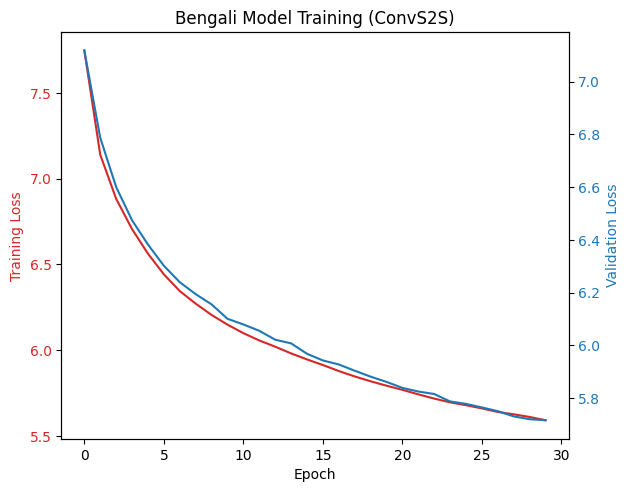

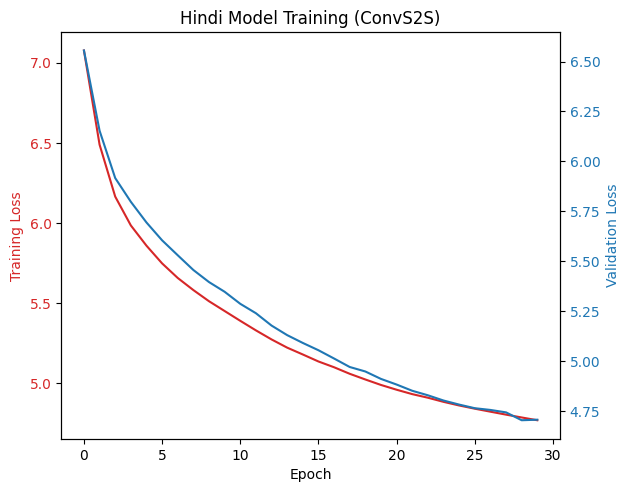

In [19]:
# === Train English-Bengali Model ===
bn_model = create_convs2s_model(
    len(bn_en_word2index), len(bn_tgt_word2index),
    bn_tgt_word2index["<PAD>"], device,
    EMB_DIM, HID_DIM, ENC_LAYERS, DEC_LAYERS,
    ENC_KERNEL_SIZE, DEC_KERNEL_SIZE, DROPOUT,
    max_len=seq_length 
)
bn_optimizer = create_optimizer(bn_model, LEARNING_RATE)
bn_scheduler = create_scheduler(bn_optimizer) # <--- CREATE SCHEDULER
bn_criterion = create_criterion(bn_tgt_word2index["<PAD>"])

bn_model_save_name = 'best_bengali_model_convs2s.pt'
if os.path.exists(bn_model_save_name):
    print(f"Loading weights from {bn_model_save_name} to continue training...")
    bn_model.load_state_dict(torch.load(bn_model_save_name, map_location=device))

bn_model, bn_history = train_model(
    bn_model, bn_train_loader, bn_val_loader,
    bn_optimizer, bn_scheduler, bn_criterion, device, # <--- PASS SCHEDULER
    seq_length,
    epochs=30, 
    early_stopping_patience=5,
    model_save_name=bn_model_save_name,
    accumulation_steps=4
)

# === Train English-Hindi Model ===
hi_model = create_convs2s_model(
    len(hi_en_word2index), len(hi_tgt_word2index),
    hi_tgt_word2index["<PAD>"], device,
    EMB_DIM, HID_DIM, ENC_LAYERS, DEC_LAYERS,
    ENC_KERNEL_SIZE, DEC_KERNEL_SIZE, DROPOUT,
    max_len=seq_length
)
hi_optimizer = create_optimizer(hi_model, LEARNING_RATE)
hi_scheduler = create_scheduler(hi_optimizer) # <--- CREATE SCHEDULER
hi_criterion = create_criterion(hi_tgt_word2index["<PAD>"])

hi_model_save_name = 'best_hindi_model_convs2s.pt'
if os.path.exists(hi_model_save_name):
    print(f"Loading weights from {hi_model_save_name} to continue training...")
    hi_model.load_state_dict(torch.load(hi_model_save_name, map_location=device))

hi_model, hi_history = train_model(
    hi_model, hi_train_loader, hi_val_loader,
    hi_optimizer, hi_scheduler, hi_criterion, device, # <--- PASS SCHEDULER
    seq_length,
    epochs=30,
    early_stopping_patience=5,
    model_save_name=hi_model_save_name,
    accumulation_steps=4
)

# [Plotting code remains the same]
def plot_history(history, title):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color)
    if history['train_loss']:
        ax1.plot(history['train_loss'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Loss', color=color) 
    if history['val_loss']:
        ax2.plot(history['val_loss'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.title(title)
    plt.show()

if 'bn_history' in locals() and bn_history['train_loss']:
    plot_history(bn_history, "Bengali Model Training (ConvS2S)")
else:
    print("Bengali training history not available for plotting.")

if 'hi_history' in locals() and hi_history['train_loss']:
    plot_history(hi_history, "Hindi Model Training (ConvS2S)")
else:
    print("Hindi training history not available for plotting.")

In [20]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import TensorDataset
import json # Ensure json is imported

# --- Function to prepare test data for ONE language (using its specific vocab) ---
def prepare_transformer_test_data(source_sentences_test, en_word2index, seq_length, language_name):
    print(f"\n--- Preparing test data for {language_name} Inference ---")

    if not source_sentences_test:
        print(f"No test sentences provided for {language_name}.")
        return None

    # 1. Preprocess the test sentences (Tokenize)
    print("Preprocessing test sentences...")
    english_final_test_tokens = [preprocess_sentence(s) for s in source_sentences_test]

    # 2. Encode and Pad using the specific English vocabulary
    print("Encoding and padding test sentences...")
    final_test_encoded = [encode_and_pad(en_word2index, sent_tokens, seq_length)
                          for sent_tokens in english_final_test_tokens]

    # Convert to NumPy array then Tensor
    final_test_x = np.array(final_test_encoded)
    # Use .long() for indices and create dataset of source tensors only
    final_test_ds = TensorDataset(torch.from_numpy(final_test_x).long())

    print(f"Test TensorDataset created for {language_name} with {len(final_test_ds)} sentences.")
    return final_test_ds

# --- Prepare data for both languages using their respective vocabs ---
# Assuming bn_src_test_raw, hi_src_test_raw, bn_en_word2index, hi_en_word2index exist

bn_final_test_ds = prepare_transformer_test_data(bn_src_test_raw, bn_en_word2index, seq_length, "Bengali")
hi_final_test_ds = prepare_transformer_test_data(hi_src_test_raw, hi_en_word2index, seq_length, "Hindi")

print("\n--- Test Data Preparation for Transformer Complete ---")


--- Preparing test data for Bengali Inference ---
Preprocessing test sentences...
Encoding and padding test sentences...
Test TensorDataset created for Bengali with 19672 sentences.

--- Preparing test data for Hindi Inference ---
Preprocessing test sentences...
Encoding and padding test sentences...
Test TensorDataset created for Hindi with 23085 sentences.

--- Test Data Preparation for Transformer Complete ---


In [ ]:
import torch
from tqdm import tqdm
import pandas as pd
import os
from torch.amp import autocast
from torch.utils.data import DataLoader 
import numpy as np
import json
import torch.nn.functional as F

# --- NEW: Batched Beam Search Function ---
# This function is much smarter than greedy search and produces better sentences.
# It's a "hybrid" batch-by-batch model for simplicity.
def predict_beam_search_words(
    model, 
    test_loader, 
    trg_word2index,
    trg_index2word,
    device, 
    max_len=64,
    beam_width=2  # You can experiment with 3, 5, or 7
):
    "Generates predictions using a batched beam search."
    
    model.eval()
    
    trg_sos_idx = trg_word2index["<SOS>"]
    trg_eos_idx = trg_word2index["<EOS>"]
    
    all_final_predictions = [] # Stores the final decoded sentences

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating Predictions (Beam Search)"):
            
            src_tensor_batch = batch[0].to(device) # Shape: [B, T_src]
            current_batch_size = src_tensor_batch.shape[0]
            
            # --- 1. Run encoder ONCE for the entire batch ---
            with torch.amp.autocast(device_type='cuda', enabled=True):
                encoder_conved, encoder_combined = model.encoder(src_tensor_batch)

            # --- 2. Loop over each sentence in the batch ---
            # A fully batched beam search is very complex.
            # This hybrid approach is a great balance of speed and simplicity.
            for i in range(current_batch_size):
                
                # Get the encoder outputs for the single sentence
                # Unsqueeze(0) to add a batch dim of 1
                enc_conv_i = encoder_conved[i, :, :].unsqueeze(0)
                enc_comb_i = encoder_combined[i, :, :].unsqueeze(0)

                # --- 3. Initialize beams for this sentence ---
                # A hypothesis is (sequence, score)
                start_seq = torch.LongTensor([[trg_sos_idx]]).to(device)
                hypotheses = [(start_seq, 0.0)]
                completed_hypotheses = []

                # --- 4. Loop for token generation ---
                for _ in range(max_len - 1):
                    if not hypotheses:
                        break
                        
                    new_hypotheses = []
                    
                    for seq, score in hypotheses:
                        # If the last token is EOS, this beam is finished
                        if seq[0, -1].item() == trg_eos_idx:
                            completed_hypotheses.append((seq, score))
                            continue
                        
                        # Run the decoder for the current hypothesis
                        with torch.amp.autocast(device_type='cuda', enabled=True):
                            output, _ = model.decoder(
                                seq, 
                                enc_conv_i, 
                                enc_comb_i
                            )
                        
                        # Get the logits for the *last* token
                        # output shape: [1, current_len, Vocab]
                        logits = output[:, -1, :] # Shape: [1, Vocab]
                        log_probs = F.log_softmax(logits, dim=-1) # Shape: [1, Vocab]

                        # Get the top k predictions
                        top_k_probs, top_k_indices = torch.topk(log_probs, beam_width)
                        
                        # --- 5. Create new hypotheses from the beams ---
                        for k in range(beam_width):
                            new_token_idx = top_k_indices[0, k].unsqueeze(0).unsqueeze(0) # Shape: [1, 1]
                            new_prob = top_k_probs[0, k].item()
                            
                            new_seq = torch.cat([seq, new_token_idx], dim=1) # Shape: [1, current_len + 1]
                            new_score = score + new_prob
                            
                            new_hypotheses.append((new_seq, new_score))
                    
                    # Prune the beams: keep only the top k across all possibilities
                    hypotheses = sorted(new_hypotheses, key=lambda x: x[1], reverse=True)[:beam_width]
                
                # Add any remaining hypotheses to the completed list
                completed_hypotheses.extend(hypotheses)
                
                # --- 6. Select the best completed hypothesis ---
                if not completed_hypotheses:
                    best_seq = torch.LongTensor([[trg_sos_idx, trg_eos_idx]]).to(device)
                else:
                    # Normalize by length to avoid favoring short sentences
                    best_hyp = max(completed_hypotheses, key=lambda x: x[1] / len(x[0][0]))
                    best_seq = best_hyp[0]

                # --- 7. Decode the best sequence using your original vocab ---
                words = []
                for idx_item in best_seq.cpu().squeeze(0).tolist()[1:]: # Skip <SOS>
                    if idx_item == trg_eos_idx:
                        break
                    if idx_item < len(trg_index2word):
                        word = trg_index2word[idx_item]
                        if word not in ["<PAD>", "<UNK>", "<SOS>"]:
                            words.append(word)
                    else:
                        words.append("<UNK>") # Handle potential out-of-bounds
                
                all_final_predictions.append(" ".join(words))

    return all_final_predictions


# --- UPDATED: Main prediction loop to call beam search ---
def predict_language_beam(
    test_ds,
    id_test_lang,
    language_name,
    model,
    trg_word2index,
    trg_index2word,
    device,
    seq_length
):
    print(f"\n--- Generating translations for {language_name} (Batched Beam Search) ---")
    
    # Create the DataLoader *inside* this function
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    # --- Call the new beam search function ---
    submission_translations = predict_beam_search_words(
        model, test_loader, trg_word2index, trg_index2word, device, seq_length, beam_width=3
    )
    
    # --- Check for length mismatch ---
    if len(submission_translations) != len(id_test_lang):
        print(f"Error: Mismatch in prediction count!")
        print(f"Expected {len(id_test_lang)} translations, but generated {len(submission_translations)}")
        min_len = min(len(submission_translations), len(id_test_lang))
        submission_translations = submission_translations[:min_len]
        id_test_lang = id_test_lang[:min_len]

    # --- Save to CSV ---
    df_submission = pd.DataFrame({
        "ID": id_test_lang,
        "Translation": submission_translations
    })
    
    # Give it a new name to avoid confusion with greedy search
    output_filename = f"answers{'B' if language_name == 'Bengali' else 'H'}_convs2s_beam.csv"
    df_submission.to_csv(output_filename, index=False)
    print(f"\n{output_filename} created successfully!")
    return output_filename


# --- Run predictions using the specific models and vocabs ---

# Predict Bengali
bn_model_path = 'best_bengali_model_convs2s.pt' 
bn_csv = None
if os.path.exists(bn_model_path) and bn_final_test_ds is not None:
    print(f"\nLoading best Bengali ConvS2S model from {bn_model_path}...")
    bn_model_pred = create_convs2s_model(
        len(bn_en_word2index), len(bn_tgt_word2index),
        bn_tgt_word2index["<PAD>"], device,
        EMB_DIM, HID_DIM, ENC_LAYERS, DEC_LAYERS,
        ENC_KERNEL_SIZE, DEC_KERNEL_SIZE, DROPOUT,
        max_len=seq_length
    )
    bn_model_pred.load_state_dict(torch.load(bn_model_path, map_location=device))

    bn_csv = predict_language_beam(
        bn_final_test_ds, bn_id_test, "Bengali", bn_model_pred,
        bn_tgt_word2index, bn_tgt_index2word,
        device, seq_length
    )
else:
    print("\nSkipping Bengali prediction: Model file or test data not found.")

# Predict Hindi
hi_model_path = 'best_hindi_model_convs2s.pt'
hi_csv = None
if os.path.exists(hi_model_path) and hi_final_test_ds is not None:
    print(f"\nLoading best Hindi ConvS2S model from {hi_model_path}...")
    hi_model_pred = create_convs2s_model(
        len(hi_en_word2index), len(hi_tgt_word2index),
        hi_tgt_word2index["<PAD>"], device,
        EMB_DIM, HID_DIM, ENC_LAYERS, DEC_LAYERS,
        ENC_KERNEL_SIZE, DEC_KERNEL_SIZE, DROPOUT,
        max_len=seq_length
    )
    hi_model_pred.load_state_dict(torch.load(hi_model_path, map_location=device))

    hi_csv = predict_language_beam(
        hi_final_test_ds, hi_id_test, "Hindi", hi_model_pred,
        hi_tgt_word2index, hi_tgt_index2word, 
        device, seq_length
    )
else:
     print("\nSkipping Hindi prediction: Model file or test data not found.")


# --- Combine and Zip (This section is unchanged) ---
try:
    if bn_csv and hi_csv:
        print(f"\nLoading '{bn_csv}' and '{hi_csv}'...")
        df_bengali = pd.read_csv(bn_csv)
        df_hindi = pd.read_csv(hi_csv)

        combined_df = pd.concat([df_bengali, df_hindi], ignore_index=True)
        output_filename = "answer.csv"
        print(f"Creating '{output_filename}' with tab separation and quotes...")

        with open(output_filename, "w", encoding='utf-8') as f:
          f.write("ID\tTranslation\n")
          for index, row in combined_df.iterrows():
            translation_text = str(row["Translation"]) if pd.notna(row["Translation"]) else ""
            translation_text = translation_text.replace('"', '""')
            f.write(f'{row["ID"]}\t"{translation_text}"\n')

        print(f"'{output_filename}' created successfully!")
        print("Zipping 'answer.csv' into 'submission.zip'...")
        !zip -j submission.zip answer.csv
    else:
        print("\nCould not create final submission.zip as one or both prediction files are missing.")
except FileNotFoundError as e:
    print(f"Error: Could not find the file {e.filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


Loading best Bengali ConvS2S model from best_bengali_model_convs2s.pt...
Creating ConvS2S Model...
ConvS2S Model created and weights initialized.

--- Generating translations for Bengali (Batched Beam Search) ---


Generating Predictions (Beam Search):  56%|█████▋    | 346/615 [2:09:44<1:42:57, 22.97s/it]